In [1]:
%matplotlib inline

import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

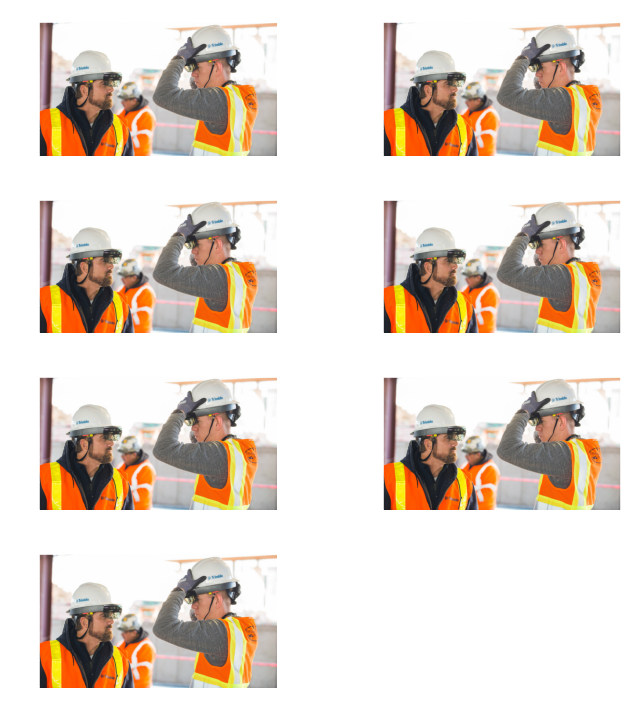

In [2]:
 # list of all the cascades available to us 
cascades_list = {
    'face_cascade': cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_default.xml'),
    'face_cascade_alt':cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_alt.xml'), 
    'face_cascade_alt2':cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_alt2.xml'),
    'profileface_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_profileface.xml'),
    'eye_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_eye.xml'),
    'full_body':cv2.CascadeClassifier('./classifiers/haarcascade_fullbody.xml'),
    'upperbody_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_upperbody.xml'),    
}

  
# create a function to detect face 
def detect_class(_img, cascade):
    '''
    Args:   _img: cv2.imread image type
            cascade: cv2.CascadeClassifier type
    Returns: img: cv2 image type
    ''' 
      
    img = _img.copy() 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      
    class_rect = cascade.detectMultiScale(img,scaleFactor = 1.3,minNeighbors = 5) 
      
    for (x, y, w, h) in class_rect: 
        cv2.rectangle(_img, (x, y),  
                      (x + w, y + h), (0, 255, 0), 10)
          
    return _img 
  
  
# Reading in the image and creating copies 
img = cv2.imread('./images/pos_1.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plotting the image and the classifiers we get
plt.figure(1, figsize=(10, 10))

for i, k in enumerate(cascades_list):
    face = detect_class(img.copy(), cascades_list[k])
    plt.subplot(421 + i)
    plt.title('{}'.format(k))
    plt.imshow(face)

plt.tight_layout()
plt.show()



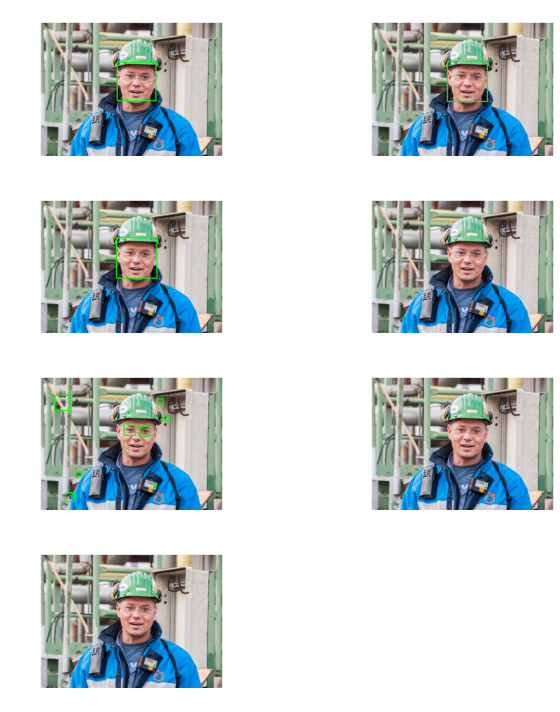

In [4]:
# Reading in the image and creating copies 
img = cv2.imread('./images/pos_641.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Using Classifiers
plt.figure(1, figsize=(10, 10))

for i, k in enumerate(cascades_list):
    face = detect_class(img.copy(), cascades_list[k])
    plt.subplot(421 + i)
    plt.title('{}'.format(k))
    plt.imshow(face)

plt.tight_layout()
plt.show()

In [2]:
class skinDetector(object):

    def __init__(self, img):
        self.image_mask = []
        self.output = []
        self.image = img
        if self.image is None:
            print("IMAGE NOT FOUND")
            exit(1)
            # self.image = cv2.resize(self.image,(600,600),cv2.INTER_AREA)
        self.HSV_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        self.YCbCr_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCR_CB)
        self.binary_mask_image = self.HSV_image

    def find_skin(self):
        self.__color_segmentation()
        self.__region_based_segmentation()

    def __color_segmentation(self):
        lower_HSV_values = np.array([0, 40, 0], dtype="uint8")
        upper_HSV_values = np.array([25, 255, 255], dtype="uint8")

        lower_YCbCr_values = np.array((0, 138, 67), dtype="uint8")
        upper_YCbCr_values = np.array((255, 173, 133), dtype="uint8")

        # A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
        mask_YCbCr = cv2.inRange(self.YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
        mask_HSV = cv2.inRange(self.HSV_image, lower_HSV_values, upper_HSV_values)

        self.binary_mask_image = cv2.add(mask_HSV, mask_YCbCr)

    def __region_based_segmentation(self):
        # morphological operations
        image_foreground = cv2.erode(self.binary_mask_image, None, iterations = 3)  # remove noise
        dilated_binary_image = cv2.dilate(self.binary_mask_image, None, iterations = 3)  # The background region is reduced a little because of the dilate operation
        ret, image_background = cv2.threshold(dilated_binary_image, 1, 128,cv2.THRESH_BINARY)  #set all background regions to 128

        # add both foreground and backgroud, forming markers. The markers are "seeds" of the future image regions.
        image_marker = cv2.add(image_foreground, image_background)
        image_marker32 = np.int32(image_marker)  # convert to 32SC1 format

        cv2.watershed(self.image, image_marker32)
        m = cv2.convertScaleAbs(image_marker32)  # convert back to uint8

        # bitwise of the mask with the input image
        ret, image_mask = cv2.threshold(m, 0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        self.image_mask = image_mask
        self.output = cv2.bitwise_and(self.image, self.image, mask= image_mask)

    def getMask(self):
        return self.image_mask

    def show_images(self):
        self.show_image(self.image)
        self.show_image(self.image_mask)
        self.show_image(self.output)

    def show_image(self, image):
        plt.imshow(image, 'gray')
        plt.show("Image")

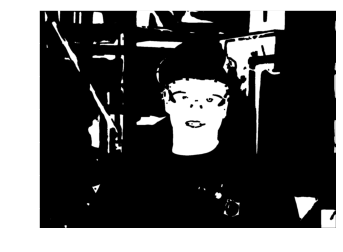

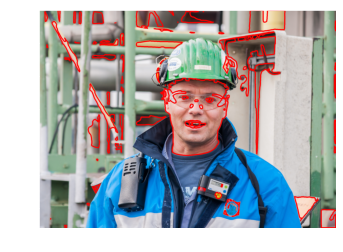

In [10]:
img = cv2.imread('./images/pos_641.jpg')

def openCloseMask(mask, iterations = 2):
    # Create structural element
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))

    # perform opening and closing on the image until all the blobs have been removed for this 
    # particular mask and gaps have been filled
    newMask = mask.copy()
    for i in range(iterations):
        newMask = cv2.morphologyEx(newMask, cv2.MORPH_OPEN, shape)
        newMask = cv2.morphologyEx(newMask, cv2.MORPH_CLOSE, shape)

    return newMask

def getContours(binary_img):
    # find contours
    contours, hierarchy = cv2.findContours(binary_img, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

    # sort the contours by size
    newContours = sorted(contours, key=cv2.contourArea, reverse=True)
    return newContours

def getSkinMask(img):
    # image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    skinD = skinDetector(img)
    skinD.find_skin()   
    return skinD.getMask()

def getGradientMag(gray_img):
    #  get the gradient magnitude using x & y sobel filters
    g_mag = cv2.magnitude(
        cv2.Sobel(gray_img, ddepth=cv2.CV_64F, dx=1, dy=0),
        cv2.Sobel(gray_img, ddepth=cv2.CV_64F, dx=0, dy=1)
     )
    g_mag = cv2.normalize(src=g_mag, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
    return g_mag

def processHelmet(img, lower, upper):
    # convert to hsv
    hsvImage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # lower_green = np.array([65,60,60])
    # upper_green = np.array([255,255,255])
    helmet_mask = cv2.inRange(hsvImage,lower,upper)

    finalMask = openCloseMask(helmet_mask, 2)
    helmet_roi = cv2.bitwise_and(img, img, mask=finalMask)
    return helmet_roi

# def getRectPercentage(skin_mask, faces):


#     return percentage

def preProcess(img):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    face_cascade = cv2.CascadeClassifier('./classifiers/haarcascade_smile.xml')
    faces = face_cascade.detectMultiScale(gray, 1.15, 8)
    # faces = face_cascade.detectMultiScale(gray, 1.18, 11,None,(35,35),(200,200))
    # facesRectangles = []
    # for x, y, width, height in faces:
    #     cv2.rectangle(image, (x, y), (x + width, y + height), color=(0, 0, 255), thickness=5)

    ### 

    smooth_img = cv2.fastNlMeansDenoising(img.copy(), h=7)   # noise removal
    skinMask = getSkinMask(smooth_img) # removes skin

    plt.imshow(skinMask, 'gray')
    plt.show()

    contours = getContours(skinMask)
    cv2.drawContours(image, contours, contourIdx=-1, color=(255,0,0), thickness=5)

    # for c in contours:
    #     peri = cv2.arcLength(c, True)
    #     poly = cv2.approxPolyDP(c, 0.02*peri, True)
    #     if len(poly) > 6:
    #         rect = cv2.boundingRect(c)
    #         cv2.rectangle(img, rect, color=(0,255,0), thickness=4)

    return image

plt.imshow(preProcess(img))
plt.show()
